# Mid term November 22, 2024

## Imports

In [1]:
import sympy
import math
from IPython.display import display, Math
from robotic.manipulator import JointType, Manipulator
from robotic.utils import draw_frame
from robotic.transformations import (
    Axis,
    EulerOrder,
    EulerSequence,
    HomogeneousTransformation,
    Rotation,
    Translation,
    X,
    Y,
    Z,
)


## Esercise 1

We begin by defining the initial orientation $R_i$ using fixed $ZXY$ euler angles, where the angles are known and can be substituted directly:

$$
\alpha = \frac{\pi}{2}, \beta = \frac{\pi}{4}, \gamma = \frac{\pi}{6}
$$

In [2]:
alpha = sympy.pi / 2
beta = sympy.pi / 4
gamma = -sympy.pi / 4
initial_rot: Rotation = Rotation.from_euler(
    (alpha, beta, gamma),
    EulerSequence.ZXY,
    EulerOrder.FIXED,
)
initial_rot.evalf().round(4)

Matrix([
[   0.5, -0.7071,     0.5],
[0.7071,       0, -0.7071],
[   0.5,  0.7071,     0.5]])

Next, the final orientation $R_f$ is specified using an axis-angle representation with axis of rotation and amount known:

$$
\bold{r} =(0, -\frac{\sqrt{2}}{2},\frac{\sqrt{2}}{2}), \quad \theta= \frac{\pi}{6}
$$ 

In [3]:
theta = sympy.pi / 6
r = Axis(0, -math.sqrt(2) / 2.0, math.sqrt(2) / 2.0)
final_rot = Rotation.from_axis_angle(r, theta)
final_rot.evalf().round()

Matrix([
[ 0.866, -0.3536, -0.3536],
[0.3536,   0.933,  -0.067],
[0.3536,  -0.067,   0.933]])

Now we compute the relative transformation $R_{if}$ which represents the rotation that brings the initial frame $R_i$ into alignment with the final frame $R_f$:

$$
R_f = R_i R_{if} \rightarrow R_{if} = R_i^T R_f
$$

In [4]:
r_trans: Rotation = initial_rot.T @ final_rot
r_trans.evalf().round()

Matrix([
[ 0.8598, 0.4495, 0.2424],
[-0.3624, 0.2026, 0.9097],
[ 0.3598,  -0.87, 0.3371]])

Finally we can extract the Eler angles $\phi, \chi, \psi$ around YXY assuming a fixed convention

In [5]:
(phi, chi, psi), _, _ = r_trans.to_euler(EulerSequence.YXY, EulerOrder.FIXED)
display(Math(rf"\phi = {phi.evalf(): .4f}"))  # type: ignore
display(Math(rf"\chi = {chi.evalf(): .4f}"))  # type: ignore
display(Math(rf"\psi = {psi.evalf(): .4f}"))  # type: ignore


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

## Excercise 2

In order to check the intermediate results we will define the required symbols

In [6]:
h, r, d, alpha, theta, phi = sympy.symbols("h r d alpha theta phi")

Now, from the figure we know that the cylinder frame is rotated relative to the world frame:

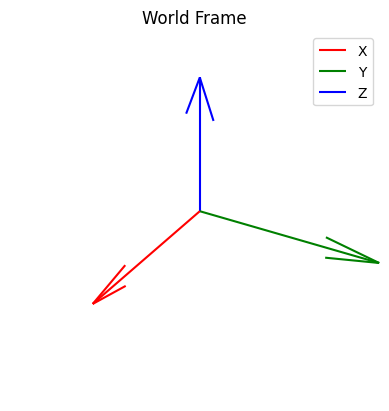

In [7]:
basis = Rotation(
    sympy.Matrix(
        [
            [0, 1, 0],
            [-1, 0, 0],
            [0, 0, 1],
        ]
    )
)
world_frame_rotation = draw_frame(basis=basis, label="World Frame")

From the image the cylinder is rotated by an amount of:

- $\frac{\pi}{2}$ around Y
- $\frac{\pi}{2}$ around Z


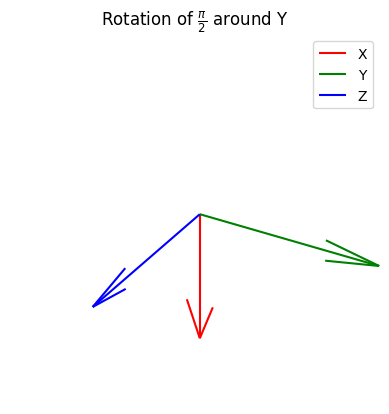

In [8]:
initial_rotation = draw_frame(
    rotation=Rotation.from_axis_angle(Y, sympy.pi / 2),
    basis=basis,
    label=r"Rotation of $\frac{\pi}{2}$ around Y",
)

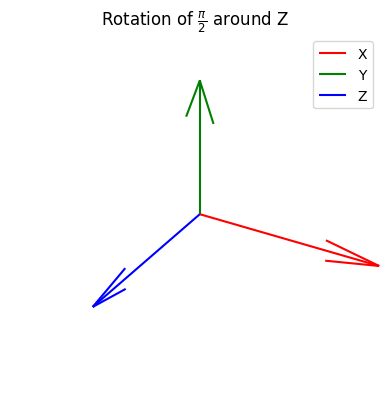

In [9]:
initial_rotation = draw_frame(
    rotation=Rotation.from_axis_angle(Z, sympy.pi / 2),
    basis=initial_rotation,
    label=r"Rotation of $\frac{\pi}{2}$ around Z",
)

We can define now an homogeneous transformation, ${}^wT_c$, that transforms from world frame into body frame, from this new initial rotation, however we need to also account for the displacement w.r.t to the center, due to the fact that we are taking the body of the cylinder, which is located at a distance of $\frac{h}{2}$ along the world frame $x$ axis and at a height of $r$, again in the world frame

In [10]:
# remove the information about the world frame basis definition
initial_rotation = basis.T @ initial_rotation
w_t_c = HomogeneousTransformation.from_rotation(initial_rotation).with_translation(
    Translation(h / 2, 0, r)
)
w_t_c

Matrix([
[0, 0, 1, h/2],
[1, 0, 0,   0],
[0, 1, 0,   r],
[0, 0, 0,   1]])

We roll for a distance $d$, however a roll will also cause a rotation $\alpha = \frac{d}{r}$, however since the roll will be clockwise $\alpha = -\frac{d}{r}$, so our first transformation $T_1$ will be described in body frame as:

In [11]:
t_1 = HomogeneousTransformation.from_rotation(
    Rotation.from_axis_angle(Z, alpha)
).with_translation(Translation(d, 0, 0))
t_1

Matrix([
[cos(alpha), -sin(alpha), 0, d],
[sin(alpha),  cos(alpha), 0, 0],
[         0,           0, 1, 0],
[         0,           0, 0, 1]])

We now rotate around the world frame Z axis, so in world frame $T_2$ will be described as

In [12]:
t_2 = HomogeneousTransformation.from_rotation(Rotation.from_axis_angle(Z, theta))
t_2

Matrix([
[cos(theta), -sin(theta), 0, 0],
[sin(theta),  cos(theta), 0, 0],
[         0,           0, 1, 0],
[         0,           0, 0, 1]])

Finally we need to define the last transformation $T_3$ which is a rotation along the cylinder Z axis

In [13]:
t_3 = HomogeneousTransformation.from_rotation(Rotation.from_axis_angle(Z, phi))
t_3

Matrix([
[cos(phi), -sin(phi), 0, 0],
[sin(phi),  cos(phi), 0, 0],
[       0,         0, 1, 0],
[       0,         0, 0, 1]])

Finally we can write the full transformation, by rememebering something very important, we first need to perform the first rotation ${}^wT_c$, which rotates into the body frame, now from here:

- any rotation in body frame will be postmultiplied
- any rotation in world frame will be premultiplied

$$
T = T_2 ({}^wT_c T_1 T_3)
$$ 

In [14]:
t = t_2 @ (w_t_c @ (t_1 @ t_3))
# sympy.simplify(t)
t

Matrix([
[-(-sin(alpha)*sin(phi) + cos(alpha)*cos(phi))*sin(theta), -(-sin(alpha)*cos(phi) - sin(phi)*cos(alpha))*sin(theta), cos(theta), -d*sin(theta) + h*cos(theta)/2],
[ (-sin(alpha)*sin(phi) + cos(alpha)*cos(phi))*cos(theta),  (-sin(alpha)*cos(phi) - sin(phi)*cos(alpha))*cos(theta), sin(theta),  d*cos(theta) + h*sin(theta)/2],
[               sin(alpha)*cos(phi) + sin(phi)*cos(alpha),               -sin(alpha)*sin(phi) + cos(alpha)*cos(phi),          0,                              r],
[                                                       0,                                                        0,          0,                              1]])

In [15]:
t = (
    HomogeneousTransformation(
        t.subs(
            {
                "h": 0.5,
                "r": 0.1,
                "d": 1.5,
                "theta": sympy.pi / 3,
                "phi": -sympy.pi / 2,
                # When a cylinder rotates of a displacement d
                # the angle is d/r
                "alpha": -1.5 / 0.1,
            }
        )
    )
    .evalf()
    .round(4)
)
t

Matrix([
[ 0.5632,  0.6579,   0.5, -1.174],
[-0.3251, -0.3798, 0.866, 0.9665],
[ 0.7597, -0.6503,     0,    0.1],
[      0,       0,     0,    1.0]])

## Exercise 3

The DH convention requires that we assign a coordinate frame to each joint such that:

- The $z_i$ axis corresponds to the axis of motion of the $i$-th joint
- The $x_i$ axis lies along the common normal between $z_i$ and $z_{i-1}$
- PER PROBLEM REQUEST: No axis should point into the sheet

We will start by visualizing the world frame that we will be using

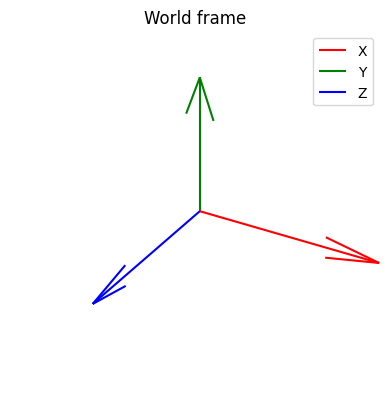

In [16]:
world_frame = draw_frame(
    label = "World frame"
).round().evalf()

Now we define Frame 0, which corresponds to the frame attached to the prismatic Joint 1, which is a sliding vertical joint.
Since the directionin which the joint moves is vertical.
Since this is the first frame that we are positioning, no previous frame exists and thus the requirement for $x_0$ is lifted and can be placed arbitrarily.
This means that we should only find a transformation $T_0$ that aligns $z_0$ with $y_w$.

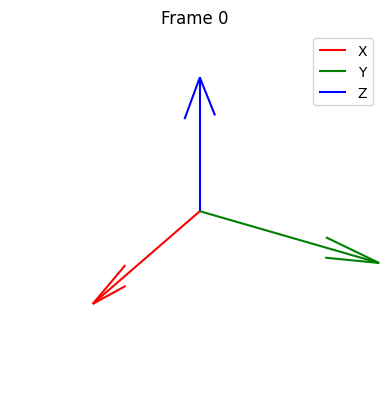

In [17]:
t_0 = draw_frame(
    Rotation.from_axis_angle(Z, -math.pi / 2)
    @ Rotation.from_axis_angle(Y, -math.pi / 2),basis= world_frame, label = "Frame 0"
).round().evalf()

Frame 1 corresponds to the second prismatic joint.
The axis is horizontal (in the world frame), so we need to find another transformation $T_1$ that allows us to move from Frame 0 to Frame 1 while respecting the constraints

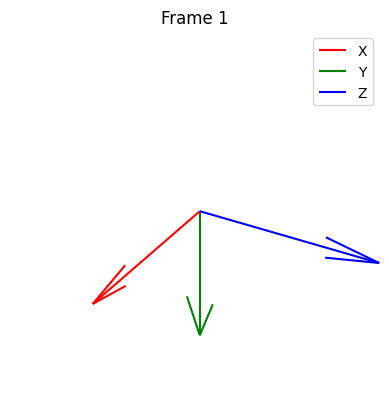

In [18]:
t_1 = draw_frame(Rotation.from_axis_angle(X,-math.pi/2), basis = t_0, label ="Frame 1").round().evalf()

Frame 2 is exactly the same as Frame 1 

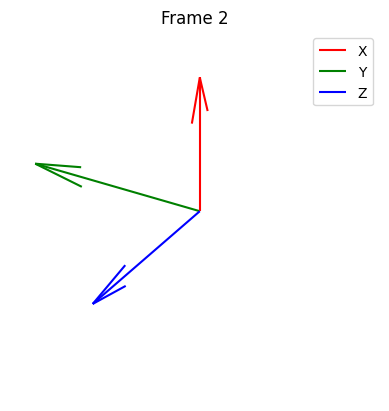

In [19]:
t_2 = draw_frame(Rotation.from_axis_angle(Z,-math.pi/2) @ Rotation.from_axis_angle(X,-math.pi/2),basis = t_1, label = "Frame 2").round().evalf()

<!-- TODO: Ask de luca how the third frame was decided  -->
Finally Frame 3 is placed at the gripper center ...

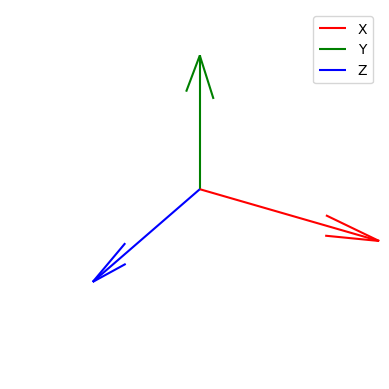

In [20]:
t_3 = draw_frame(Rotation.from_axis_angle(Z,-math.pi/2),basis = t_2).round().evalf()

And finally we need to add the End effector frame, but as the text suggests $z_e$ should be in the approach direction and $y_e$ should be in the slide direction.

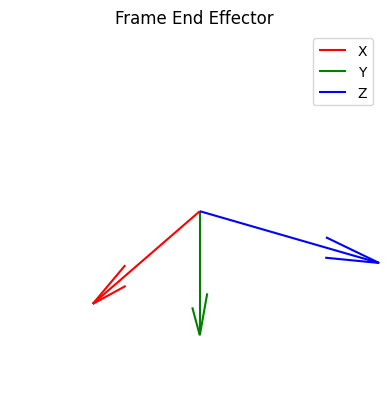

In [21]:
t_e = draw_frame(Rotation.from_axis_angle(Y,math.pi/2) @ Rotation.from_axis_angle(Z,math.pi), basis = t_3,label = "Frame End Effector").round().evalf()

Now that we have defined all axes, we can compute the DH table by interpreting the transformation between each pair of frames. We'll go parameter by parameter.

### Twist angle $\alpha_i$

> **With respect to $x_i$, how much do we need to rotate $z_{i-1}$ to align it with $z_i$?**

In practice, this is just the rotation around the X-axis between consecutive Z-axes. Since we aligned the axes visually, we can directly read the rotation by observing the relative orientation of $z_{i-1}$ and $z_i$.

- $\alpha_1 = -\frac{\pi}{2}$
- $\alpha_2 = -\frac{\pi}{2}$
- $\alpha_3 = 0$

*Note: These correspond to the rotations around X applied when constructing each frame using `draw_frame`.*

---

### Link length $a_i$

> **The distance from $z_{i-1}$ to $z_i$, measured along the $x_i$ direction.**

This is easier to reason about in most cases. There are only two main situations:

- If $z_{i-1}$ and $z_i$ are **parallel but not intersecting**, then $a_i = c$, where $c$ is the distance between them.
- If $z_{i-1}$ and $z_i$ **intersect or are colinear**, then $a_i = 0$.

In our case:

- $a_1 = 0$
- $a_2 = 0$
- $a_3 = L$ (since the third link extends a constant length along the $x_3$ direction)

---

### Offset $d_i$

> **The distance along the $z_{i-1}$ (or $z_i$) axis from the origin of frame $i-1$ to where the common normal meets it.**

This parameter is variable for **prismatic joints**, and constant (often zero) for **revolute joints**.

- $d_1 = q_1$ (first prismatic joint)
- $d_2 = q_2$ (second prismatic joint)
- $d_3 = 0$ (revolute joint)

---

### Joint angle $\theta_i$

> **The angle between $x_{i-1}$ and $x_i$, measured about the $z_{i-1}$ axis.**

We can simply check how much rotation occurred around the Z-axis between each pair of frames.

- $\theta_1 = 0$
- $\theta_2 = -\frac{\pi}{2}$
- $\theta_3 = q_3$ (revolute joint angle)


We can now generate the dh Matrix

In [22]:
joint_types = [
        JointType.PRISMATIC,
        JointType.PRISMATIC,
        JointType.REVOLUTE,
    ]
# a
link_lengths = [0, 0, sympy.symbols("L")]
# alpha
link_twists = [-sympy.pi / 2, -sympy.pi / 2, 0]
man = Manipulator(
    link_lengths=link_lengths,
    link_twists=link_twists,
    joint_types=joint_types,
    theta_offsets=[0.0, -sympy.pi / 2, 0],
)
man.dh_table()



   a  alpha    d  theta       type
0  0  -pi/2  q_1    0.0  PRISMATIC
1  0  -pi/2  q_2  -pi/2  PRISMATIC
2  L      0    0    q_3   REVOLUTE

In [23]:
man.dh_matrix().evalf()

Matrix([
[        0,         0, 1.0,                 0],
[-sin(q_3), -cos(q_3),   0, -L*sin(q_3) + q_2],
[ cos(q_3), -sin(q_3),   0,  L*cos(q_3) + q_1],
[        0,         0,   0,               1.0]])

In [24]:
HomogeneousTransformation.from_rotation(t_0) @ man.dh_matrix() @ HomogeneousTransformation.from_rotation(t_3)

Matrix([
[-1.0*sin(q_3),    0, 1.0*cos(q_3), -1.0*L*sin(q_3) + 1.0*q_2],
[            0, -1.0,            0,                         0],
[ 1.0*cos(q_3),    0, 1.0*sin(q_3),  1.0*L*cos(q_3) + 1.0*q_1],
[            0,    0,            0,                         1]])

In [25]:
w_t_zero = world_frame.T @ t_0
w_t_zero

Matrix([
[  0, 1.0,   0],
[  0,   0, 1.0],
[1.0,   0,   0]])

In [28]:
three_t_e = t_3.T @ t_e
three_t_e

Matrix([
[  0,    0, 1.0],
[  0, -1.0,   0],
[1.0,    0,   0]])

In [27]:
(w_t_zero @ man.dh_matrix() @ three_t_e).as_translation().evalf()

Matrix([
[-1.0*L*sin(q_3) + 1.0*q_2],
[ 1.0*L*cos(q_3) + 1.0*q_1],
[                        0]])

## Excercise 4